# 8. Final project

Notebook to recognize and categorize taps in an image


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

First, load the dataset:
We see there are:
* 1 tap  rounded black
* 1 tap  rounded white
* 3 taps rounded blue
* 2 taps rounded red
* 2 taps squared red
* 1 tap  squared yellow
* 1 tap  elliptical pink

Given all these, in some pictures maybe some of there are not include. 
We assume this taps have always same size.




Steps:

1. Load image
2. Convert tu RGB
3. Crop image


## Crop image

We crop the image as there is too much backround above and below ROI. These parts of the background (top and bottom) are affected by the light (lighter), so cropping the images we assure a better change to detect lighter objects.

In [8]:
image = cv2.imread('final_project_imgs/5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_copy = image.copy()
image_original = image.copy()
# image_copy =  cv2.resize(image_copy,(600,600))

# crop images
print(image_copy.shape) #(4000, 3000)
image_copy = image_copy[500:3300, :]
gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)


(4000, 3000, 3)


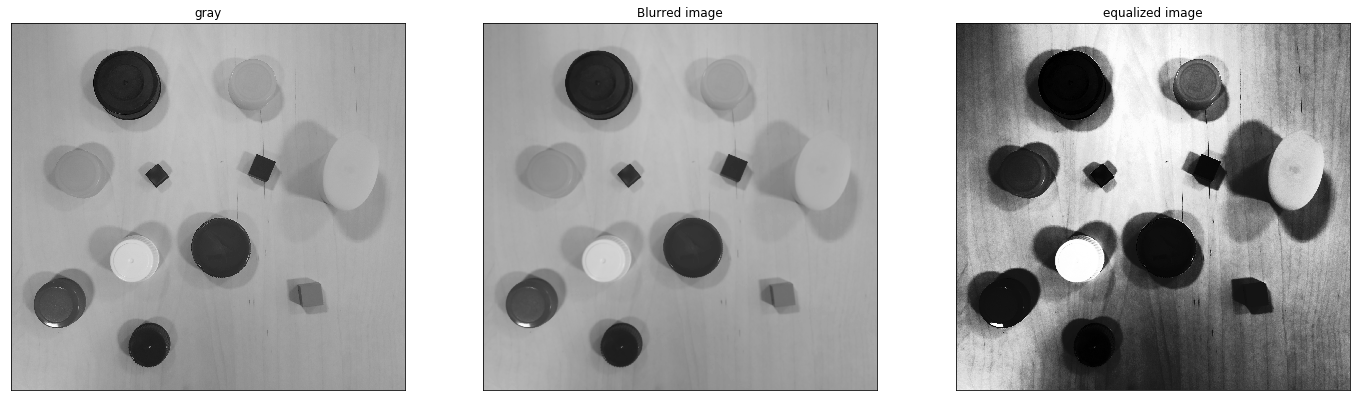

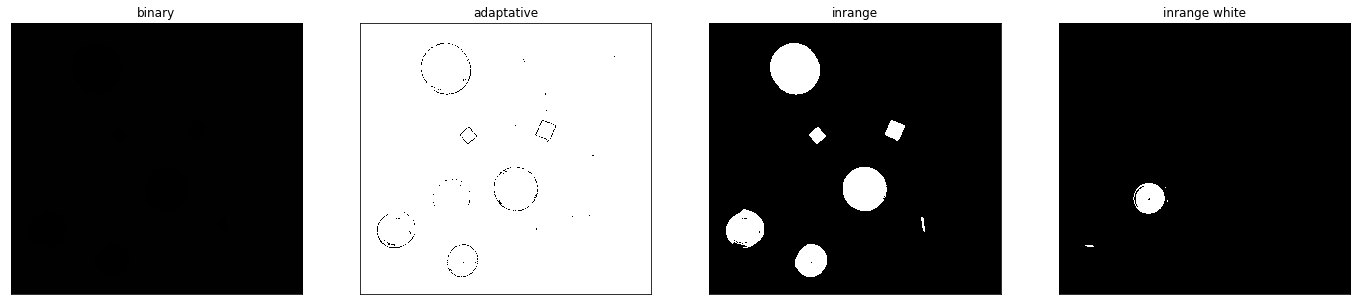

In [3]:
# blurred = cv2.GaussianBlur(gray, (5,5), 0)
# like gaussian, but transform only pixels with same intensity values. Because of that,
# is highly effective in noise removal while keeping edges sharp
blurred = cv2.bilateralFilter(gray, 15, 75, 75)



# contrast  (equalization)
equal_image = cv2.equalizeHist(gray)

th_binary = cv2.threshold(blurred, 100, 1, cv2.THRESH_BINARY)[1]
th_adaptative = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
th_inrange = cv2.inRange(blurred, 0, 90)
th_inrange_white = cv2.inRange(blurred, 200, 255)

cv2.imwrite('11.jpg', gray)


# contrast  (equalization)
equal_image = cv2.equalizeHist(gray)

fig, axes = plt.subplots(1, 3, figsize=(24,12))
axes[0].imshow(gray, cmap='gray',  vmin=0, vmax=255)
axes[0].set_title('gray')
axes[1].imshow(blurred, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Blurred image')
axes[2].imshow(equal_image, cmap='gray',  vmin=0, vmax=255)
axes[2].set_title('equalized image')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])


# contrast  (equalization)
equal_image = cv2.equalizeHist(gray)

fig, axes = plt.subplots(1, 4, figsize=(24,12))
axes[0].imshow(th_binary, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('binary')
axes[1].imshow(th_adaptative, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('adaptative')
axes[2].imshow(th_inrange, cmap='gray', vmin=0, vmax=255)
axes[2].set_title('inrange')
axes[3].imshow(th_inrange_white, cmap='gray', vmin=0, vmax=255)
axes[3].set_title('inrange white')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])



## Postprocessing

In the images below, we can see how we applied 2 `inrange` filters, one for darker colors and one for the white one.

[]

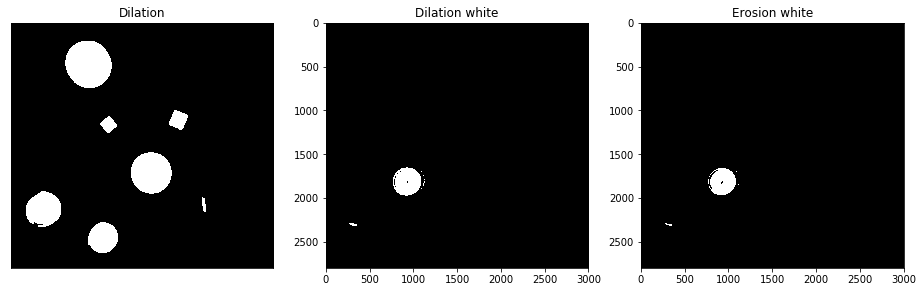

In [4]:
# Note that we can use different kernels if needed
kernel = np.ones((5,5),np.float32)/225

# Dilation for inrange dark
erosion = cv2.erode(th_inrange_white, kernel, iterations = 1)
dilation = cv2.dilate(th_inrange, kernel, iterations = 3)
dilation_white = cv2.dilate(th_inrange_white, kernel, iterations = 1) # CAREFUL, BIG DILATION, CHECK IN OTHER PICTURES.


fig, axes = plt.subplots(1, 3, figsize=(16, 12))
axes[0].imshow(dilation, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Dilation')
axes[1].imshow(dilation_white, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('Dilation white')
axes[2].imshow(erosion, cmap='gray', vmin=0, vmax=255)
axes[2].set_title('Erosion white')
axes[0].set_xticks([])
axes[0].set_yticks([])



Find contours and draw them in original image

Text(0.5, 1.0, 'Original image contoured')

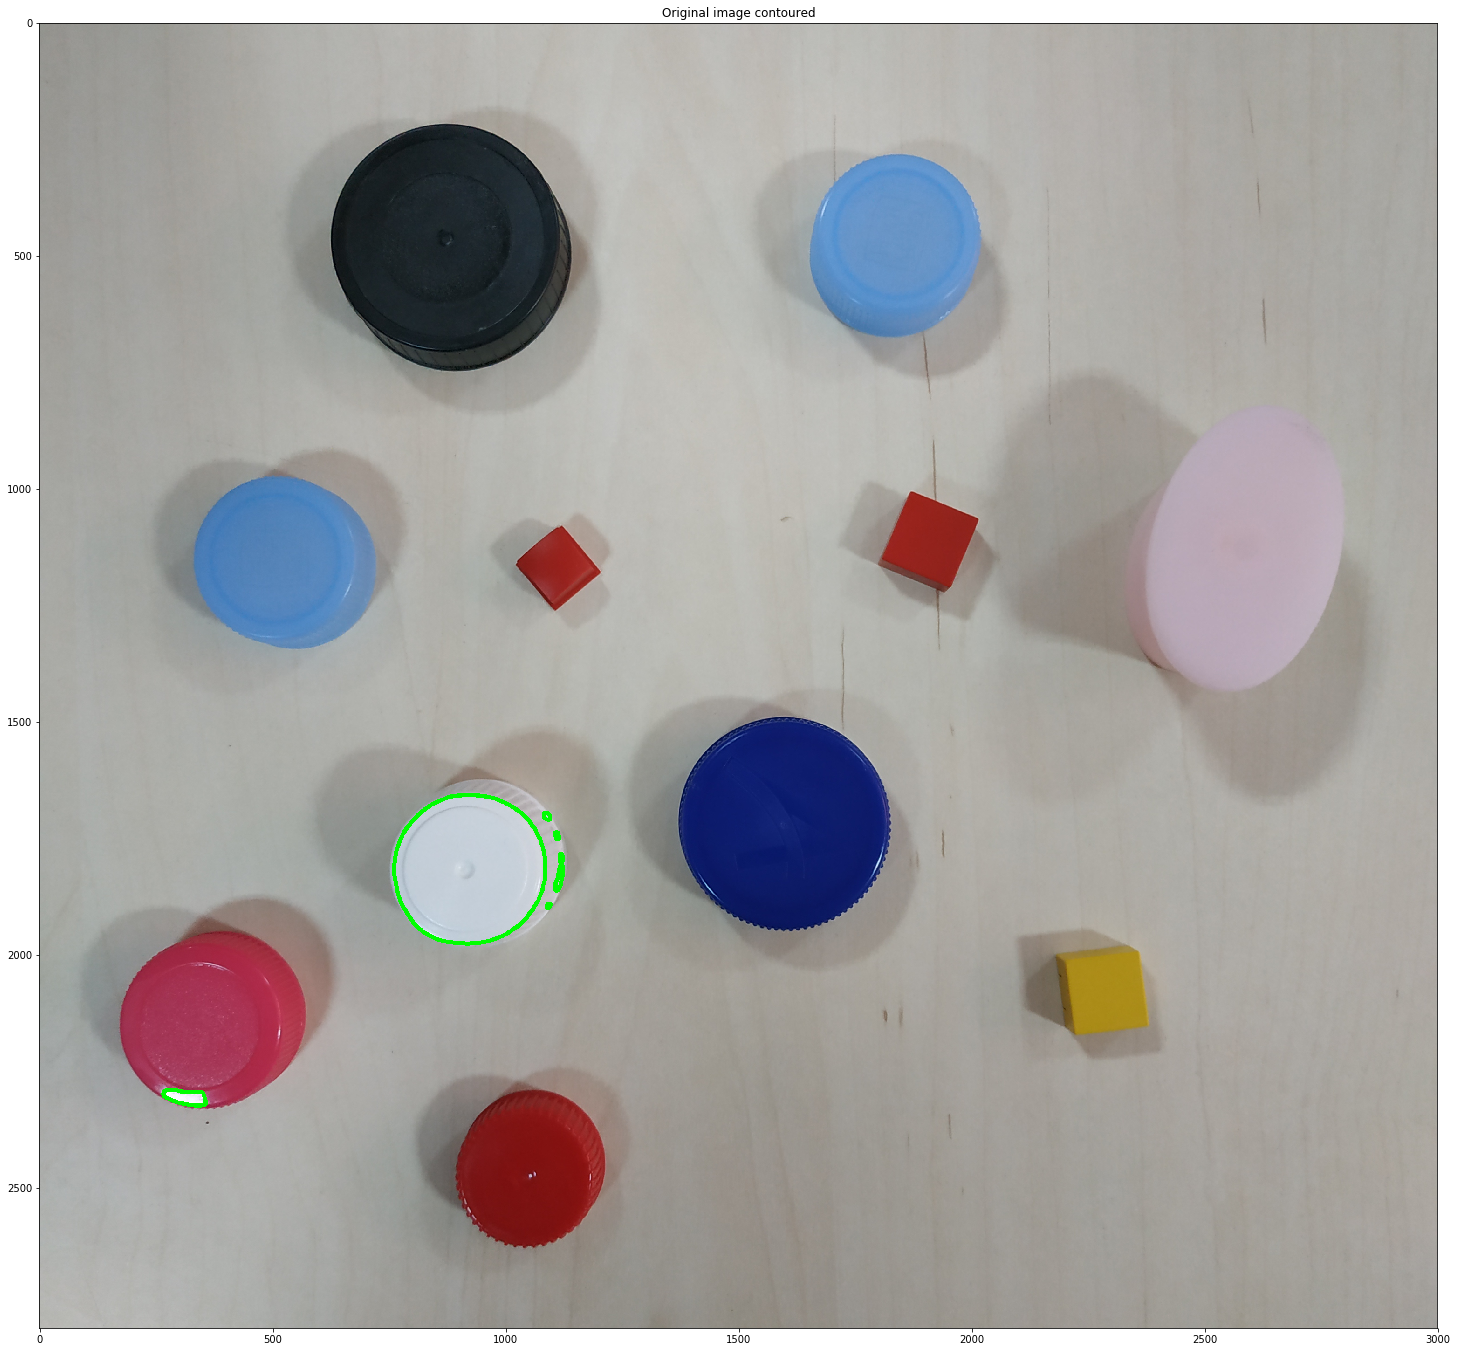

In [5]:
# Find contours in the thresholded image
cnts = cv2.findContours(dilation_white, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Grab the appropriate tuple value based on whether 
# we are using OpenCV 2.4, 3, or 4.
cnts = imutils.grab_contours(cnts)

# (image,contours,number of contours (-1 = all),color to draw, width (-1 =filled)
cv2.drawContours(image_copy, cnts, -1, (0, 255, 0), 8)

# show thresholded image
fig, axes = plt.subplots(1, 1, figsize=(48, 24))
axes.imshow(image_copy, cmap='gray', vmin=0, vmax=255)
axes.set_title('Original image contoured')

We see there are a lot of contours when we just want one, the white one. So now, we filter by area to reduce contours to just the desires

In [ ]:
for contour in cnts:
        area = cv2.contourArea(contour)
        print(area)

def clean_contours_by_area(contours, min_size, max_size, min_circularity):
    """filter all contours by size to prevent noise"""
    filtred_contours  = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if (area < max_size) & (area > min_size):
            perimeter = cv2.arcLength(contour, True)
            filtred_contours.append(contour)
    return filtred_contours

cnts_filtred = clean_contours_by_area(cnts,15000,1000000,0.5)
cv2.drawContours(image_original, cnts_filtred, -1, (0, 255, 0), 8)

print('Number of contours found: ',len(cnts_filtred))


# show image
fig, axes = plt.subplots(1, 1, figsize=(48, 24))
axes.imshow(image_original, cmap='gray', vmin=0, vmax=255)
axes.set_title('Original image contoured')

2152.5
60.0
479.5
102.5
96.5
158.5
82217.0
Number of contours found:  1


Text(0.5, 1.0, 'Original image contoured')